In [1]:
import pandas as pd
import numpy as np
from nlpUtils import aardvark as aa 
from numpy import random as rand
from sklearn.metrics import f1_score, roc_curve, auc

import seaborn as sns
import matplotlib.pyplot as plt

import torch
from transformers import logging
logging.set_verbosity_error()  # Turns off the warning when you load the model without training
from transformers import BertForSequenceClassification
from transformers import BertTokenizerFast
from transformers import BertTokenizer

# from transformers import DistilBertModel
# from transformers import DistilBertForSequenceClassification
# from transformers import DistilBertTokenizer

# Load the dataset

In [40]:
x_train = pd.read_csv("x_train_2.csv", header=0, index_col=0) # the _2 version dropped irrelevant columns
x_val = pd.read_csv("x_val_2.csv", header=0, index_col=0)
y_train_sent = pd.read_csv("y_train_sent.csv", header=0, index_col=0)
y_val_sent = pd.read_csv("y_val_sent.csv", header=0, index_col=0)

print(x_train.shape)
print(x_val.shape)
print(y_train_sent.shape)
print(y_val_sent.shape)
x_train.tail()

(742, 4)
(319, 4)
(742, 2)
(319, 2)


,id_stable,Date,Content,ContentClean
506,25533,2022-01-16 18:30:03+00:00,@AP Ok let the questions being. Did the Terror...,Ok let the questions being. Did the Terrorist ...
769,106799,2021-08-28 10:13:32+00:00,@campbellclaret Sooooooo agree!\nNow then talk...,Sooooooo agree! Now then talk us through Afgha...
712,183663,2021-07-22 14:58:14+00:00,"Today I’m voting to pass the ALLIES Act, which...","Today I’m voting to pass the ALLIES Act, which..."
102,66047,2021-09-23 22:47:43+00:00,"@POTUS\nMan, I know this migrant thing is bad ...","Man, I know this migrant thing is bad but coul..."
679,177479,2021-08-09 10:58:28+00:00,@hassib_haidar why is Afghan army clicking pic...,why is Afghan army clicking pictures of terror...


In [41]:
y_train_sent.tail()

,id_stable,y_sent
506,25533,1
769,106799,2
712,183663,2
102,66047,1
679,177479,1


# Setup for BERT
Thanks to: https://medium.com/mlearning-ai/twitter-sentiment-analysis-with-deep-learning-using-bert-and-hugging-face-830005bcdbbf, https://www.youtube.com/watch?v=szczpgOEdXs

Using the distilbert-base-uncased version.

Setup
1. get just the columns we will use
2. add some new columns we will need

In [ ]:
## DONT THINK I NEED THIS
# x_cols = ["id_stable", "ContentClean"]
# x_train = x_train[x_cols]
# x_val = x_val[x_cols]

# x_train["tokenIDs"] = ""
# x_val["tokenIDs"] = ""

# x_train["mask"] = ""
# x_val["mask"] = ""

# print(x_train.shape)
# print(x_val.shape)
# print(y_train_sent.shape)
# print(y_val_sent.shape)
# x_train.tail()

### Look at tweet length
Because BERT requires equal length sentences and we need to know where we want to cut/pad to.

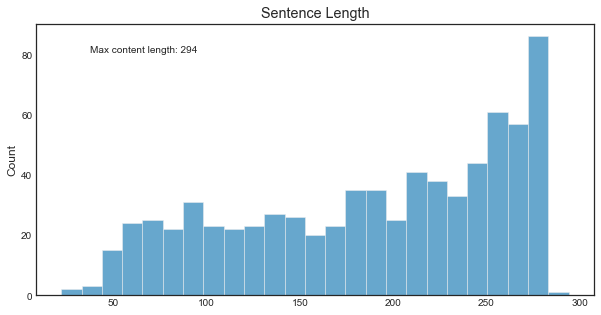

In [65]:
plt.figure(figsize=(10, 5))
sns.histplot([len(s) for s in x_train["ContentClean"]], bins=25)
plt.title('Sentence Length, number of characters')
plt.figtext(.2, .8, "Max content length: {}".format(max([len(s) for s in x_train["ContentClean"]])))
plt.style.use('ggplot') 
#plt.style.use('Solarize_Light2') 
plt.style.use('seaborn-white') 
plt.show()

In [43]:
max_tweet_len = max([len(s) for s in x_train["ContentClean"]])
max_tweet_len

294

So there are a lot of tweets that run long. I think I will pad to the max tweet length: 294.

# Setup the BERT Tokenizer and Model


In [13]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback

In [45]:
X_train = list(x_train["ContentClean"])
X_val = list(x_val["ContentClean"])
Y_train = list(y_train_sent["y_sent"])
Y_val = list(y_val_sent["y_sent"])

In [92]:
# a = len(str(X_train).split(" "))
a = [len(i.split()) for i in X_train]
max_a = (max(a))
ind_max_a = a.index(max_a)
print("length of longest tweet:", max_a)
print("index of longest tweet:", ind_max_a)
print("longest tweet:", X_train[ind_max_a])

length of longest tweet: 60
index of longest tweet: 240
longest tweet: I remember years ago in my hometown someone I know is an Afghan refugee, came to the UK at 11 as his dad & uncle were killed by the Taliban, so his mum sent him west. He was nearly deported at 17 & the only reason he wasn’t is that the local MP was a junior minister at the time.


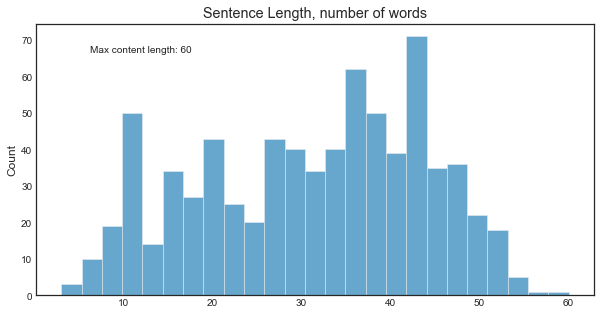

In [95]:
plt.figure(figsize=(10, 5))
sns.histplot(a, bins=25)
plt.title('Sentence Length, number of words')
plt.figtext(.2, .8, "Max content length: {}".format(max(a)))
plt.style.use('ggplot') 
#plt.style.use('Solarize_Light2') 
plt.style.use('seaborn-white') 
plt.show()

In [11]:
model_name = "bert-base-uncased"
model = BertForSequenceClassification.from_pretrained(model_name)
#tokenizer = BertTokenizerFast.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name, num_labels=3)

In [60]:
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=60)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=60)

In [61]:
## THANKS TO: https://towardsdatascience.com/fine-tuning-pretrained-nlp-models-with-huggingfaces-trainer-6326a4456e7b
# Create torch dataset 
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

# Define Trainer parameters
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

train_dataset = Dataset(X_train_tokenized, Y_train)
val_dataset = Dataset(X_val_tokenized, Y_val)


In [62]:
## THANKS TO: https://towardsdatascience.com/fine-tuning-pretrained-nlp-models-with-huggingfaces-trainer-6326a4456e7b
# Define Trainer
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    seed=0,
    load_best_model_at_end=True,
)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)
# model.resize_token_embeddings(len(tokenizer))

# Train pre-trained model
trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
## THANKS TO: https://towardsdatascience.com/fine-tuning-pretrained-nlp-models-with-huggingfaces-trainer-6326a4456e7b


# ___________ BOOKMARK - START HERE ___________

In [12]:
# for testing, take a smaller df
my_df = x_val[0:3]
my_df

,id_stable,ContentClean,tokenIDs,mask
128,145141,"80,000 unvetted people? Sounds great, even afg...",,
724,3083,if u take in a single ukranian refugee here th...,,
854,34770,Afghan refugee who arrived in Britain on the b...,,


In [14]:
def prepTokens(df):
    return tokenizer(df['ContentClean'], padding=True, truncation=True)

train_set = train_set.map(prepTokens, batched=True, 
                          batch_size=len(train_set))
#test_set = test_set.map(prepTokens, batched=True, batch_size=len(test_set))

AttributeError: 'list' object has no attribute 'map'